In [1]:
library(Seurat)
#library(SeuratDisk)
library(NMF)
library(ggalluvial)
library(ComplexHeatmap)
library(CellChat)
library(patchwork)
library(graphics)
library(Matrix)
library(circlize)
library(colorspace)
library(pracma)
library(glue)

options(stringsAsFactors = FALSE, repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 300)

source("../Scripts/B-cellType_pathways-heatmap.r")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')

Loading required package: ggplot2

Loading required package: grid

ComplexHeatmap version 2.15.4
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap pac

# Parameters

In [2]:
# for plotting figC, differential network
disease = "AD"
project = "AD_Paper"
type <- "truncatedMean"
trim <- 0.05

In [3]:
inhibitory_celltypes <- c('Chandelier', 'Lamp5', 'Lamp5 Lhx6', 'Pax6', 'Pvalb', 'Sncg', 'Sst', 'Vip', 'Sst Chodl')
excitatory_celltypes <- c('L2/3 IT', 'L4 IT', 'L5', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b')
support_celltypes <- c('Astro', 'Endo', 'Oligo', 'OPC', 'VLMC', 'Micro/PVM')
celltype_name = c('Chandelier', 'Lamp5', 'Lamp5 Lhx6', 'Pax6', 'Pvalb', 'Sncg', 'Sst', 'Vip', 'Sst Chodl', 
                  'L2/3 IT', 'L4 IT', 'L5', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 
                  'Astro', 'Endo', 'Oligo', 'OPC', 'VLMC', 'Micro/PVM')

#celltype_name = c('Astro', 'Endo', 'MG', 'Oligo', 'OPC', 
#                  'Exc CUX2', 'Exc FEZF2', 'Exc OPRK1', 'Exc RORB', 
#                  'Inh KCNG1', 'Inh LAMP5', 'Inh PVALB', 'Inh SST', 'Inh VIP')

cell_type <- 'Astro'
comm_type <- 'sender'       # "receiver", "sender"

measure = 'weight'

# Read in Data

In [4]:
cellchat.CT <- readRDS(file = "/extra/zhanglab0/CommonData/AMP-AD/Obj-CellChat/subclass_cellchat_control.rds")
cellchat.DIS <- readRDS(file = "/extra/zhanglab0/CommonData/AMP-AD/Obj-CellChat/subclass_cellchat_alz.rds")

In [5]:
cellchat.CT <- updateCellChat(cellchat.CT)
cellchat.DIS <- updateCellChat(cellchat.DIS)

Warning message in updateCellChat(cellchat.CT):
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`!”
Warning message in updateCellChat(cellchat.DIS):
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`!”


In [6]:
object.list <- list(CT = cellchat.CT, DIS = cellchat.DIS)
cellchat <- mergeCellChat(object.list, add.names = names(object.list))
print(cellchat)
names(object.list)

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



An object of class CellChat created from a merged object with multiple datasets 
 704 signaling genes.
 51171 cells. 
CellChat analysis of single cell RNA-seq data! 


[1] "CT"  "DIS"

# Sender-Receiver Cell Types Heatmap Code

Do heatmap based on a merged object 




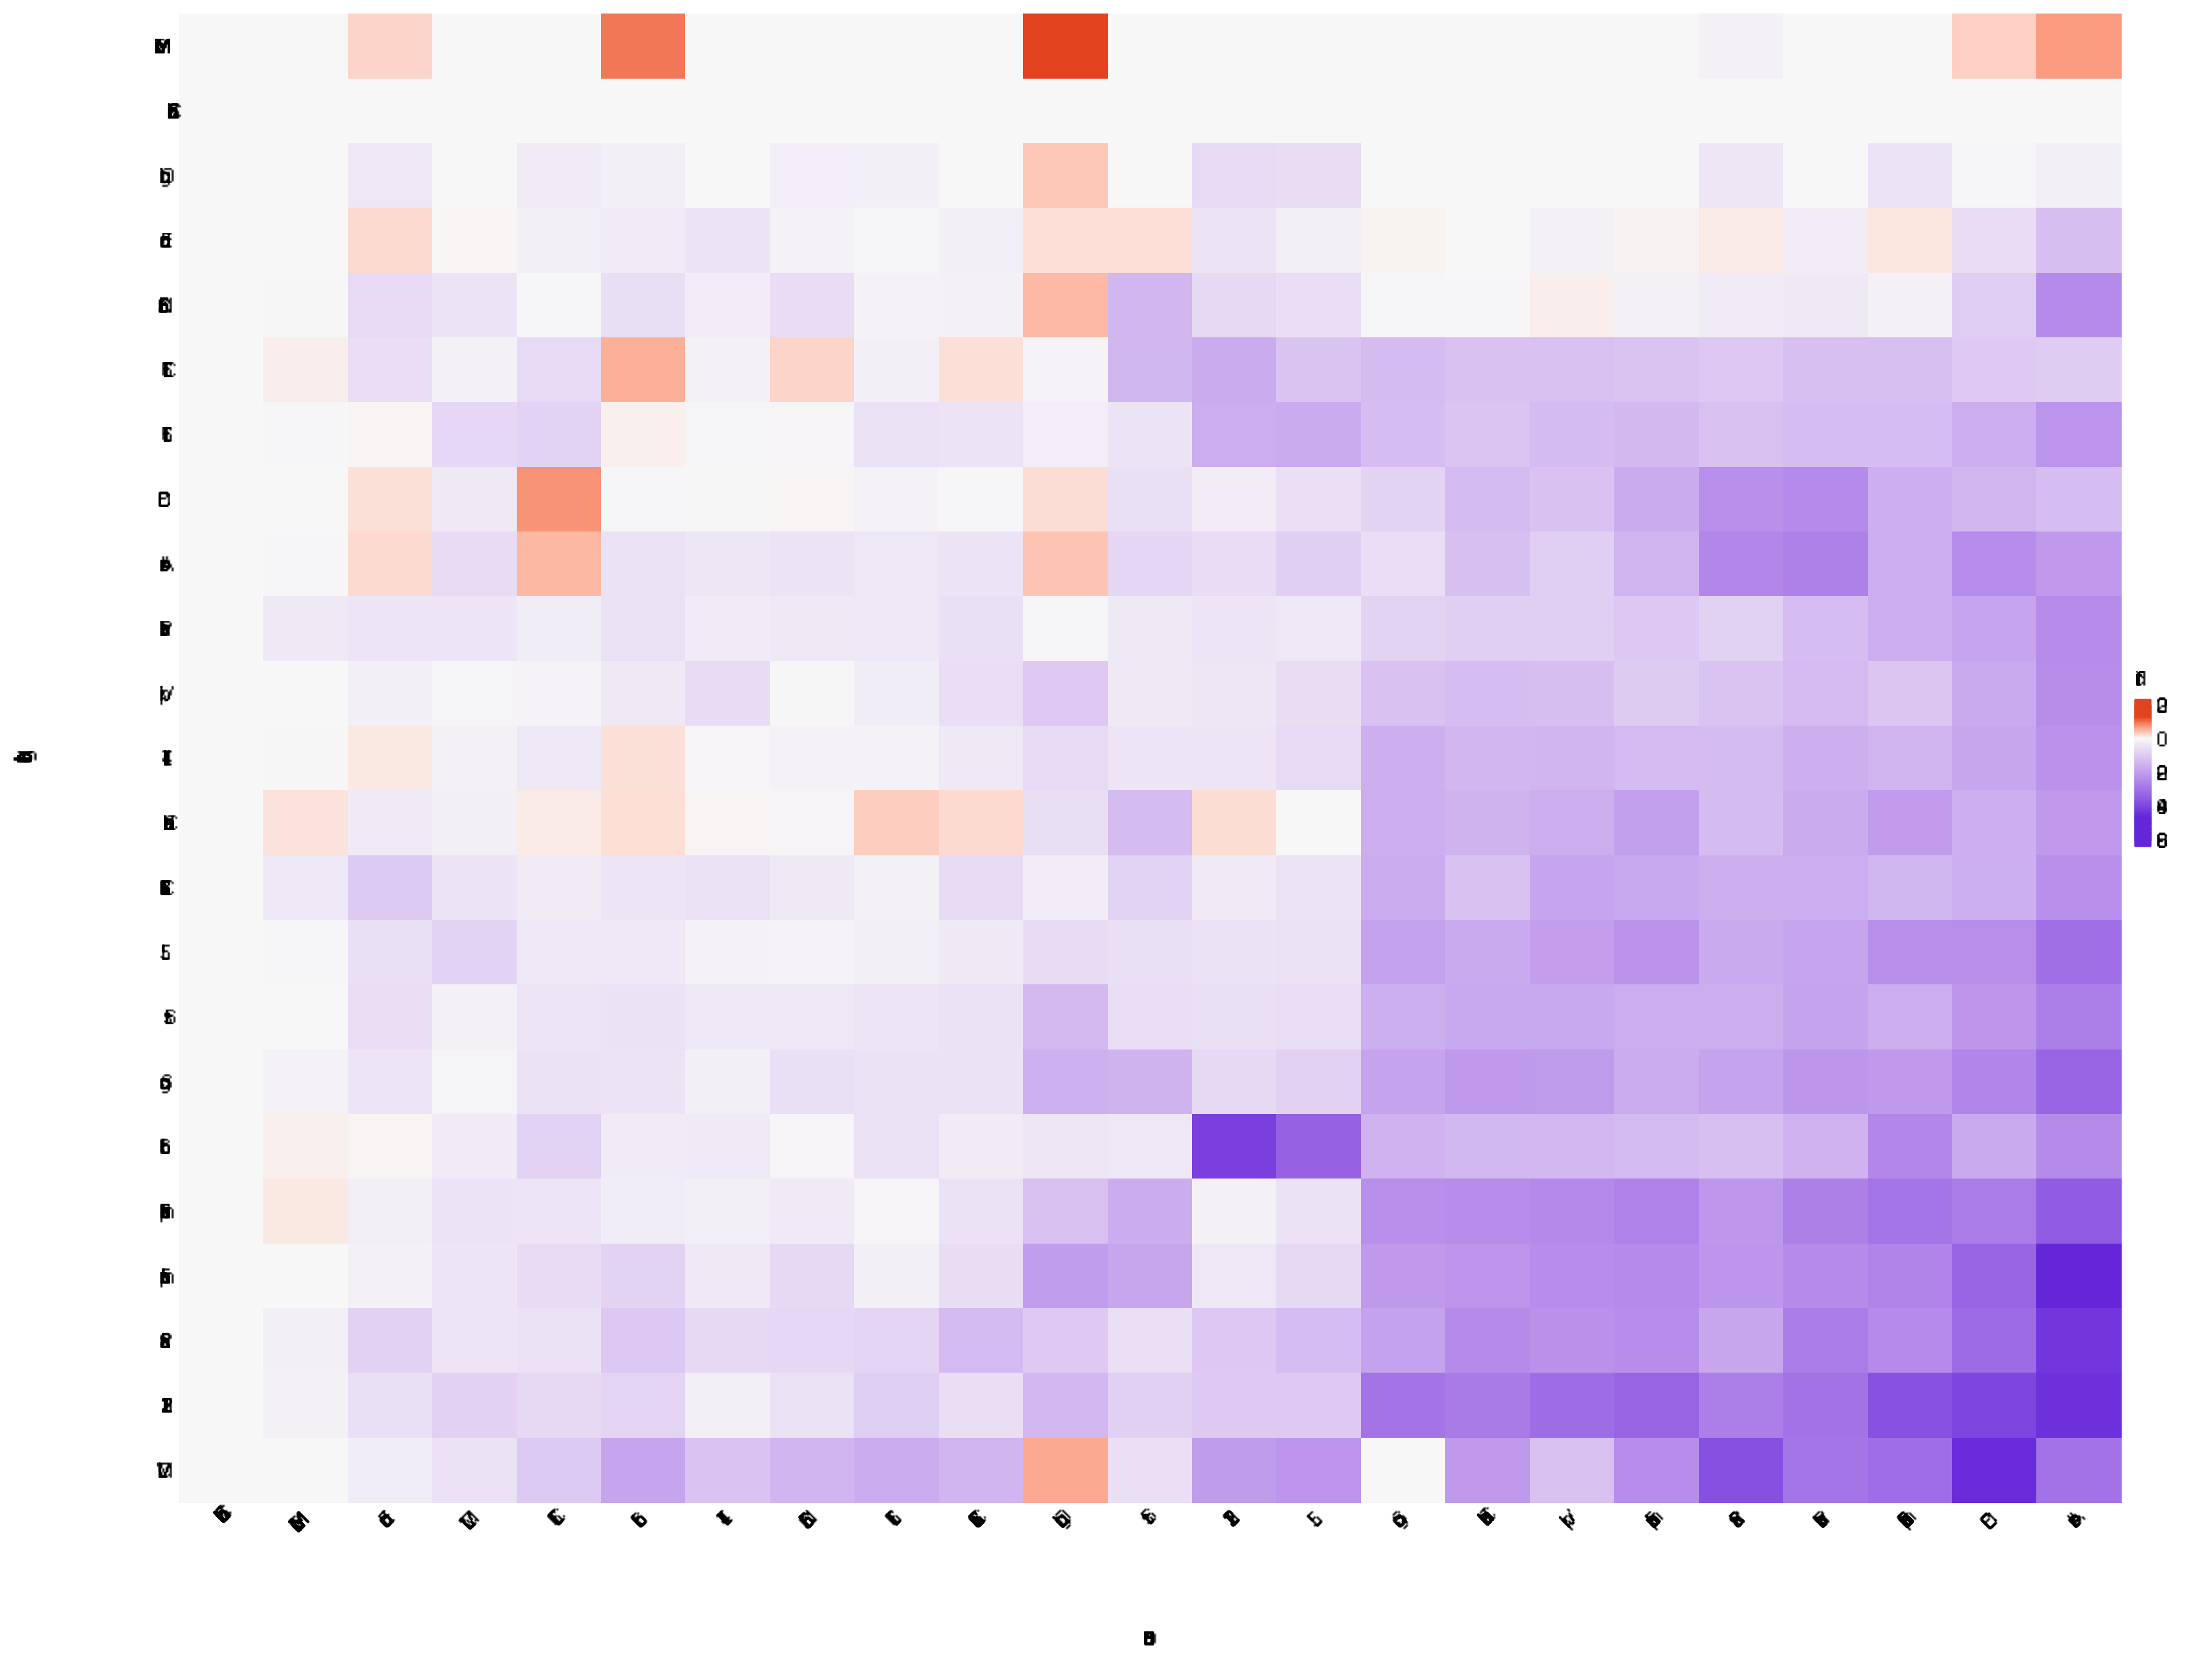

In [9]:
object <- cellchat
font.size = 8
font.size.title = 10
color.heatmap = c('#6526DA', '#E3421F')
measure <- 'weight'
title.name <- 'weight'

message("Do heatmap based on a merged object \n")
#obj1 <- object@net[[comparison[1]]][[measure]]
#obj2 <- object@net[[comparison[2]]][[measure]]

obj1 <- object.list[[1]]@net[[measure]]              # CT
obj2 <- object.list[[2]]@net[[measure]]              # DIS

net.diff <- obj2 - obj1

title.name = "strength"

legend.name = "diff"

net <- net.diff
mat <- net
if (min(mat) < 0) {
    color.heatmap.use = colorRamp3(c(min(mat), 0, max(mat)), c(color.heatmap[1], "#f7f7f7", color.heatmap[2]))
    colorbar.break <- c(round(min(mat, na.rm = T), digits = nchar(sub(".*\\.(0*).*","\\1",min(mat, na.rm = T)))+1), 0, round(max(mat, na.rm = T), digits = nchar(sub(".*\\.(0*).*","\\1",max(mat, na.rm = T)))+1))
    # color.heatmap.use = colorRamp3(c(seq(min(mat), -(max(mat)-min(max(mat)))/9, length.out = 4), 0, seq((max(mat)-min(max(mat)))/9, max(mat), length.out = 4)), RColorBrewer::brewer.pal(n = 9, name = color.heatmap))
  } else {
    if (length(color.heatmap) == 3) {
      color.heatmap.use = colorRamp3(c(0, min(mat), max(mat)), color.heatmap)
    } else if (length(color.heatmap) == 2) {
      color.heatmap.use = colorRamp3(c(min(mat), max(mat)), color.heatmap)
    } else if (length(color.heatmap) == 1) {
      color.heatmap.use = grDevices::colorRampPalette((RColorBrewer::brewer.pal(n = 9, name = color.heatmap)))(100)
    }
    colorbar.break <- c(round(min(mat, na.rm = T), digits = nchar(sub(".*\\.(0*).*","\\1",min(mat, na.rm = T)))+1), round(max(mat, na.rm = T), digits = nchar(sub(".*\\.(0*).*","\\1",max(mat, na.rm = T)))+1))
  }
ht1 = Heatmap(mat, col = color.heatmap.use, na_col = "white", name = legend.name,
              #Colv=NA, Rowv=NA, 
            cluster_rows = TRUE,cluster_columns = TRUE, row_names_side = "left",
              row_names_rot = 0,row_names_gp = gpar(fontsize = font.size),column_names_gp = gpar(fontsize = font.size),
           # width = unit(width, "cm"), height = unit(height, "cm"),
            column_title = 'source', column_title_side = 'bottom',column_title_gp = gpar(fontsize = font.size.title),column_names_rot = 45,
            show_row_dend = FALSE, show_column_dend = FALSE,
            row_title = "target",row_title_gp = gpar(fontsize = font.size.title),row_title_rot = 90,
            heatmap_legend_param = list(title_gp = gpar(fontsize = 8, fontface = "plain"),
                                        #title_position = "leftcenter-rot",
                                        border = NA, #at = colorbar.break,
                                        legend_height = unit(20, "mm"),labels_gp = gpar(fontsize = 8),grid_width = unit(2, "mm"))
)

ht1

In [10]:
pdf("Figure3C.pdf", width=10, height=10)
ht1
dev.off()

png 
  2

# Code

## Normalization

In [78]:
# get the matrix
obj1 <- object.list[[1]]@net[[measure]]              # CT
obj2 <- object.list[[2]]@net[[measure]]              # DIS
melt_1 <- reshape2::melt(obj1, value.name="count")
melt_2 <- reshape2::melt(obj2, value.name="count")
sum1 <- sum(melt_1$count)
sum2 <- sum(melt_2$count)

# balance
normalization = sum1 / sum2
# normalization = sum(object.list[[1]]@netP$prob) / sum(object.list[[2]]@netP$prob)
net.diff <- obj2 * (normalization) - obj1

# reorder the celltypes
net.diff <- net.diff[celltype_name, celltype_name]

In [79]:
colSums(net.diff)

Chandelier        Lamp5   Lamp5 Lhx6         Pax6        Pvalb         Sncg 
 0.953683549  0.496960797  0.183606443  0.362277370  0.301809852  0.905339181 
         Sst          Vip    Sst Chodl      L2/3 IT        L4 IT           L5 
-0.957502365  0.859978463  0.000000000 -1.594183024 -0.447851756 -1.655488029 
     L5/6 NP        L6 CT        L6 IT   L6 IT Car3          L6b        Astro 
-0.355798602 -0.234125747 -0.294521119 -0.657613324 -0.050791905 -0.337780325 
        Endo        Oligo          OPC         VLMC    Micro/PVM 
-0.332622021  2.906615768  0.549449702 -0.605220396  0.003777489

In [80]:
sum(net.diff_comm_slice)

[1] -0.9128398

## C2C Difference

In [90]:
data_whole.CT  <- cellchat.CT@netP$prob
data_whole.DIS <- cellchat.DIS@netP$prob * normalization

if (comm_type == "receiver") {
    comm_slice.CT  <- data_whole.CT[cell_type, , ]
    comm_slice.DIS <- data_whole.DIS[cell_type, , ]
    row_title = paste0("Sender Cell Types to ", cell_type)
} else if (comm_type == "sender") {
    comm_slice.CT  <- data_whole.CT[cell_type, , ]
    comm_slice.DIS <- data_whole.DIS[cell_type, ,]
    row_title = paste0(cell_type, " to Receiver Cell Types")
}

if (length(setdiff(colnames(comm_slice.CT), colnames(comm_slice.DIS))) > 0) {
    original_names <- colnames(comm_slice.DIS)
    for (i in 1:length(setdiff(colnames(comm_slice.CT), colnames(comm_slice.DIS)))) {
        comm_slice.DIS <- cbind(comm_slice.DIS, 0)
    }
    colnames(comm_slice.DIS) <- c(original_names, setdiff(colnames(comm_slice.CT), colnames(comm_slice.DIS)))
}

if (length(setdiff(colnames(comm_slice.DIS), colnames(comm_slice.CT))) > 0) {
    original_names <- colnames(comm_slice.CT)
    for (i in 1:length(setdiff(colnames(comm_slice.DIS), colnames(comm_slice.CT)))) {
        comm_slice.CT <- cbind(comm_slice.CT, 0)
    }
    colnames(comm_slice.CT) <- c(original_names, setdiff(colnames(comm_slice.DIS), colnames(comm_slice.CT)))
}

comm_slice.DIS <- comm_slice.DIS[, colnames(comm_slice.CT)]

net.diff_comm_slice <- comm_slice.DIS - comm_slice.CT
net.diff_comm_slice <- net.diff_comm_slice[celltype_name, abs(colSums(net.diff_comm_slice)) > 0.005]
net.diff_comm_slice <- net.diff_comm_slice[celltype_name, names(sort(colSums(net.diff_comm_slice), decreasing = TRUE))]

# Visual

In [92]:
# Draw
# pdf(file = glue("supp_fig-diff_IO-{comm_type}-{cell_type}.pdf"), width = 14, height = 8)

pdf(file = "heatmap.pdf", width = 10, height = 10)

ht1 <- Heatmap(net.diff_comm_slice, 
              name = "Diff Strength", #title of legend
              column_title = glue("Differential {disease} vs CON Pathways"), row_title = row_title, 
              column_title_gp = gpar(fontsize = 16, fontface="bold"),                                      # Column Title Font
              row_title_gp = gpar(fontsize = 16, fontface="bold"),                                                            # Row Title Font
              row_names_gp = gpar(fontsize = 12), column_names_gp = gpar(fontsize = 12),
              show_row_dend = FALSE, show_column_dend = FALSE,                                               # No dendrograms
              rect_gp = gpar(col = "white", lwd = 2),                                                        # ea cell has a white border
              col = colorRamp2(c(-max(abs(net.diff_comm_slice)), 0, max(abs(net.diff_comm_slice))), 
                                c("blue", "white", "red")),     # Set Color
              row_names_side = 'left', column_names_side = 'top', 
              heatmap_legend_param = list(legend_direction = "horizontal", legend_width = unit(5, "cm")),
              width = ncol(net.diff_comm_slice)*unit(5, "mm"), height = nrow(net.diff_comm_slice)*unit(8, "mm"),   # Row and column names on the right side
              cluster_rows = FALSE, cluster_columns = TRUE)
draw(ht1, heatmap_legend_side = "bottom")
dev.off()

png 
  2